# Analysing LogProb Data from LLMs for behaviorual Risk Preference Tasks


In [69]:
# ------------------- load packages -------------------------------------
#!pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
# ------------- load all data -------------------------------------------
# read human data and subset participants ID and DV
human_data_bart = pd.read_csv("data_humans/bart.csv") 
human_data_bart = human_data_bart[["partid", "pumps"]]
human_data_cct = pd.read_csv("data_humans/cct_overt.csv")
human_data_cct = human_data_cct[["partid", "CCTncards"]]
human_data_dfe = pd.read_csv("data_humans/dfe_perpers.csv")
human_data_dfe = human_data_dfe[["partid", "Rexp"]]
human_data_lot = pd.read_csv("data_humans/lotteriesOvert.csv")
human_data_lot = human_data_lot[["partid", "R"]]

# renaming columns for clarity
human_data_bart = human_data_bart.rename(columns={"pumps": "BART_DV"})
human_data_cct  = human_data_cct.rename(columns={"CCTncards": "CCT_DV"})
human_data_dfe  = human_data_dfe.rename(columns={"Rexp": "DFE_DV"})
human_data_lot  = human_data_lot.rename(columns={"R": "LOT_DV"})

# merge all human dfs to one
human_data = pd.merge(human_data_bart, human_data_cct, on="partid", how="inner")
human_data = pd.merge(human_data, human_data_dfe, on="partid", how="inner")
human_data = pd.merge(human_data, human_data_lot, on="partid", how="inner")


# read the LLM generated data with logprobs 
llm_data_bart = pd.read_csv("data_LLM/SmolLM2-1.7B-Instruct_bart_results.csv")
llm_data_dfe = pd.read_csv("data_LLM/SmolLM2-1.7B-Instruct_dfe_results.csv")
llm_data_cct = pd.read_csv("data_LLM/SmolLM2-1.7B-Instruct_cct_results.csv")
llm_data_lot = pd.read_csv("data_LLM/SmolLM2-1.7B-Instruct_lot_results.csv")


human_data.head()

,partid,BART_DV,CCT_DV,DFE_DV,LOT_DV
0,64000401,36.86,411.0,0.43,0.54
1,64004701,51.57,568.0,0.50,0.70
2,64006401,33.10,349.0,0.50,0.50
3,64006901,35.77,535.0,0.86,0.48
4,64007901,37.03,507.0,0.00,0.40


In [71]:
# --------------- load decision data for dfe --------------
full_trial_data_humans = pd.read_csv("data_humans/dfe_samples.csv")

# subset human data, leave only one row per round per person (i.e. 8 per person)
subset_per_trial_humans = (
    full_trial_data_humans
    .groupby(["partid", "gamble_ind"], as_index=False)
    .first()
)
 # subset important columns to keep
subset_per_trial_humans = subset_per_trial_humans[["partid","decision"]]

llm_data_dfe = pd.merge(
    subset_per_trial_humans,
    llm_data_dfe,
    left_on="partid",
    right_on="participant_id",
    how="inner"
).drop(columns=["partid"])

llm_data_dfe

,decision,round,log_prob_A,log_prob_B,participant_id,model,age,sex,location
0,A,1,-0.808594,-0.683594,64000401,SmolLM2-1.7B-Instruct,26,female,Basel
1,A,2,-0.388672,-1.140625,64000401,SmolLM2-1.7B-Instruct,26,female,Basel
2,A,3,-0.582031,-0.832031,64000401,SmolLM2-1.7B-Instruct,26,female,Basel
3,A,4,-0.353516,-1.226562,64000401,SmolLM2-1.7B-Instruct,26,female,Basel
4,A,5,-0.431641,-1.054688,64000401,SmolLM2-1.7B-Instruct,26,female,Basel
...,...,...,...,...,...,...,...,...,...
96413,A,4,-0.636719,-0.761719,68051401,SmolLM2-1.7B-Instruct,29,male,Basel
96414,A,5,-0.828125,-0.578125,68051401,SmolLM2-1.7B-Instruct,29,male,Basel
96415,A,6,-1.226562,-0.349609,68051401,SmolLM2-1.7B-Instruct,29,male,Basel
96416,A,7,-1.703125,-0.202148,68051401,SmolLM2-1.7B-Instruct,29,male,Basel


In [72]:
# -------------- Helpers -----------------------------------------------------

def add_softmax_probs(df, cols, new_cols=None):
    """
    Compute row-wise softmax probabilities from two columns and add them to the dataframe.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    cols : list of str, length=2
        Names of the two columns containing log-probabilities.
    new_cols : list of str, optional
        Names of the new probability columns. If None, defaults to ["prob_" + col for col in cols].
    
    Returns
    -------
    pd.DataFrame
        Dataframe with the new probability columns added.
    """
    if new_cols is None:
        new_cols = [f"prob_{c}" for c in cols]

    # extract values
    logprobs = df[cols].to_numpy()

    # apply softmax row-wise with numerical stability
    exp_shifted = np.exp(logprobs - logprobs.max(axis=1, keepdims=True))
    probs = exp_shifted / exp_shifted.sum(axis=1, keepdims=True)

    # make DataFrame aligned to original index
    probs_df = pd.DataFrame(probs, columns=new_cols, index=df.index)

    # return df with new cols added
    return pd.concat([df, probs_df], axis=1)



def add_normalized_choice_prob(
    df,
    decision_col,
    prob_mapping,
    new_col="prob_actual",
    normalized_col="normalized_prob",
    merge_back=False
):
    """
    Add probability of actual choice per row and normalized participant-level probability.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with a 'participant_id' column.
    decision_col : str
        Column with actual decision values (e.g., "choice_made").
    prob_mapping : dict
        Mapping from decision values to probability column names,
        e.g. {"pump": "prob_pump", "stop": "prob_stop"}.
    new_col : str, default="prob_actual"
        Name of the column to store row-wise probability of the actual choice.
    normalized_col : str, default="normalized_prob"
        Name of the column to store participant-level normalized probability (geometric mean).
    merge_back : bool, default=True
        If True, return original df with new columns merged.
        If False, return only participant-level summary (id + normalized_col).

    Returns
    -------
    pd.DataFrame
        Depending on `merge_back`, either the full dataframe with extra columns,
        or a summary dataframe with participant_id + normalized_col.
    """
    # Step 1: probability of actual choice
    df = df.copy()  # avoid modifying original inplace
    df[new_col] = df.apply(
        lambda row: row[prob_mapping[row[decision_col]]], axis=1
    )

    # Step 2: participant-level geometric mean
    participant_probs = (
        df.groupby("participant_id")[new_col]
          .agg(lambda x: np.exp(np.mean(np.log(x))))
          .rename(normalized_col)
          .reset_index()
    )

    if merge_back:
        # Step 3a: merge back into full df
        return df.merge(participant_probs, on="participant_id", how="left")
    else:
        # Step 3b: return only summary
        return participant_probs



In [73]:
llm_data_cct

,round_num,decision_num,cards_turned,current_score,choice_made,gain_points,loss_points,loss_cards,round_outcome,final_score,log_prob_turn,log_prob_stop,turn_key,stop_key,participant_id,model,experiment
0,1,1,0,0,turn,150,75,20,loss,-75,-0.328125,-2.078125,E,C,64000401,SmolLM2-1.7B-Instruct,CCT
1,2,1,0,0,turn,50,100,1,loss,100,-0.585938,-0.835938,E,C,64000401,SmolLM2-1.7B-Instruct,CCT
2,2,2,1,50,turn,50,100,1,loss,100,-0.394531,-1.140625,E,C,64000401,SmolLM2-1.7B-Instruct,CCT
3,2,3,2,100,turn,50,100,1,loss,100,-0.287109,-1.414062,E,C,64000401,SmolLM2-1.7B-Instruct,CCT
4,2,4,3,150,turn,50,100,1,loss,100,-0.255859,-1.507812,E,C,64000401,SmolLM2-1.7B-Instruct,CCT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613294,84,1,0,0,turn,50,250,3,loss,-50,-12.000000,-11.500000,Z,W,68051401,SmolLM2-1.7B-Instruct,CCT
613295,84,2,1,50,turn,50,250,3,loss,-50,-11.562500,-11.000000,Z,W,68051401,SmolLM2-1.7B-Instruct,CCT
613296,84,3,2,100,turn,50,250,3,loss,-50,-10.750000,-9.125000,Z,W,68051401,SmolLM2-1.7B-Instruct,CCT
613297,84,4,3,150,turn,50,250,3,loss,-50,-9.437500,-7.906250,Z,W,68051401,SmolLM2-1.7B-Instruct,CCT


In [74]:
# ------------- preprocess LLM data -------------------------------------------

# add normalized probability columns to LLM responses
llm_data_bart = add_softmax_probs(
    llm_data_bart,
    cols=["log_prob_pump", "log_prob_stop"],
    new_cols=["prob_pump", "prob_stop"]
)

llm_data_dfe = add_softmax_probs(
    llm_data_dfe,
    cols=["log_prob_A", "log_prob_B"],
    new_cols=["prob_A", "prob_B"]
)

llm_data_cct = add_softmax_probs(
    llm_data_cct,
    cols=["log_prob_turn", "log_prob_stop"],
    new_cols=["prob_turn", "prob_stop"]
)

llm_data_lot = add_softmax_probs(
    llm_data_lot,
    cols=["log_prob_a", "log_prob_b"],
    new_cols=["prob_A", "prob_B"]
)



# get normalized probability the LLM assigns to each person's actual behaviour

bart_llm_probs_df = add_normalized_choice_prob(
    df=llm_data_bart,
    decision_col="choice_made",
    normalized_col="BART_llm_prob",
    prob_mapping={"pump": "prob_pump", "stop": "prob_stop"},
    merge_back=False
)

dfe_llm_probs_df = add_normalized_choice_prob(
    df=llm_data_dfe,
    decision_col="decision",
    normalized_col="DFE_llm_prob",
    prob_mapping={"A": "prob_A", "B": "prob_B"},
    merge_back=False
)

cct_llm_probs_df = add_normalized_choice_prob(
    df=llm_data_cct,
    decision_col="choice_made",
    normalized_col="CCT_llm_prob",
    prob_mapping={"turn": "prob_turn", "stop": "prob_stop"},
    merge_back=False
)

lot_llm_probs_df = add_normalized_choice_prob(
    df=llm_data_lot,
    decision_col="choice_made",
    normalized_col="LOT_llm_prob",
    prob_mapping={"A": "prob_A", "B": "prob_B"},
    merge_back=False
)






cct_llm_probs_df




,participant_id,CCT_llm_prob
0,64000401,0.709996
1,64006401,0.662746
2,64006901,0.692507
3,64007901,0.674378
4,64008701,0.571297
...,...,...
1363,68050801,0.669547
1364,68050901,0.773192
1365,68051101,0.715036
1366,68051301,0.622281


In [75]:
# ------------- Merge human data with LLM probabilities -------------------------------------------


all_LLM_dfs =[bart_llm_probs_df, dfe_llm_probs_df, cct_llm_probs_df, lot_llm_probs_df]

merged = human_data
for dataset in all_LLM_dfs:
    merged = pd.merge(
    merged,
    dataset,
    left_on="partid",
    right_on="participant_id",
    how="inner"
    ).drop(columns=["participant_id"])
    
merged

,partid,BART_DV,CCT_DV,DFE_DV,LOT_DV,BART_llm_prob,DFE_llm_prob,CCT_llm_prob,LOT_llm_prob
0,64000401,36.86,411.0,0.43,0.54,0.856691,0.457233,0.709996,0.467586
1,64006401,33.10,349.0,0.50,0.50,0.863600,0.731901,0.662746,0.423446
2,64006901,35.77,535.0,0.86,0.48,0.838871,0.447295,0.692507,0.453855
3,64007901,37.03,507.0,0.00,0.40,0.847935,0.436316,0.674378,0.520535
4,64008701,43.87,304.0,0.86,0.38,0.910721,0.453817,0.571297,0.459607
...,...,...,...,...,...,...,...,...,...
1363,68050801,35.50,315.0,0.25,0.40,0.860976,0.380077,0.669547,0.450957
1364,68050901,38.59,200.0,0.83,0.42,0.866078,0.490167,0.773192,0.473901
1365,68051101,27.13,538.0,0.50,0.50,0.872462,0.517215,0.715036,0.481826
1366,68051301,25.23,259.0,0.43,0.44,0.818300,0.430598,0.622281,0.466962



--- BART ---
    BART_DV  BART_llm_prob          type
0     64.03       0.999390   most likely
1     64.03       0.999041   most likely
2     58.57       0.965428   most likely
3     60.53       0.963582   most likely
4     60.24       0.955359   most likely
5     59.63       0.955061   most likely
6     56.73       0.948579   most likely
7     56.37       0.947070   most likely
8     56.03       0.947051   most likely
9     55.47       0.946518   most likely
10     2.14       0.535685  least likely
11     6.03       0.584092  least likely
12    12.31       0.692878  least likely
13    20.80       0.701988  least likely
14    12.64       0.709727  least likely
15    19.33       0.714924  least likely
16     9.90       0.720422  least likely
17    20.70       0.721334  least likely
18    21.27       0.726429  least likely
19    20.83       0.731685  least likely


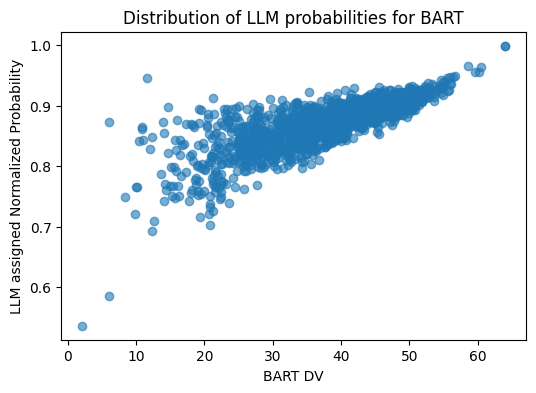


--- CCT ---
    CCT_DV  CCT_llm_prob          type
0    649.0      0.920727   most likely
1    659.0      0.886611   most likely
2    488.0      0.883159   most likely
3    400.0      0.869922   most likely
4    601.0      0.868016   most likely
5    599.0      0.862981   most likely
6    558.0      0.862424   most likely
7    654.0      0.859770   most likely
8    556.0      0.857815   most likely
9    212.0      0.855921   most likely
10    71.0      0.399785  least likely
11    82.0      0.409146  least likely
12    79.0      0.436116  least likely
13    61.0      0.439274  least likely
14   590.0      0.447740  least likely
15   132.0      0.454182  least likely
16   148.0      0.455484  least likely
17    85.0      0.463446  least likely
18   154.0      0.463999  least likely
19   559.0      0.468698  least likely


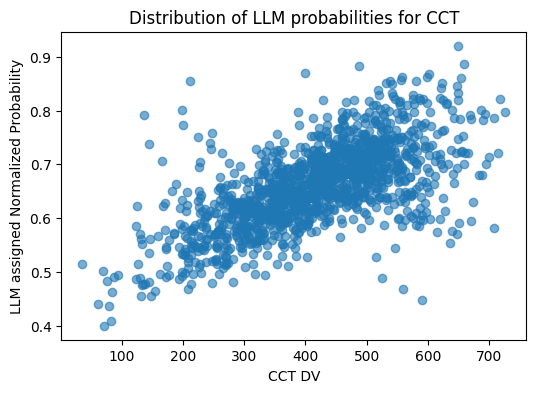


--- DFE ---
    DFE_DV  DFE_llm_prob          type
0     0.50      0.910391   most likely
1     0.50      0.883570   most likely
2     0.71      0.858470   most likely
3     0.50      0.834796   most likely
4     0.14      0.826074   most likely
5     0.50      0.805837   most likely
6     0.50      0.766223   most likely
7     0.50      0.749968   most likely
8     0.57      0.742879   most likely
9     0.43      0.731913   most likely
10    0.86      0.127102  least likely
11     NaN      0.163168  least likely
12    0.86      0.191688  least likely
13    0.50      0.196033  least likely
14    0.38      0.202644  least likely
15    0.57      0.217327  least likely
16     NaN      0.229846  least likely
17    0.38      0.231069  least likely
18    0.50      0.233000  least likely
19    0.00      0.236950  least likely


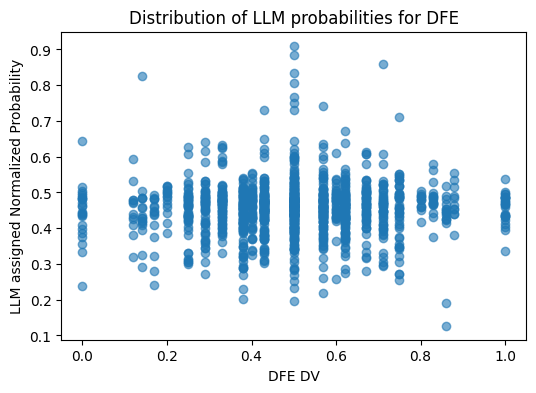


--- LOT ---
    LOT_DV  LOT_llm_prob          type
0     0.44      0.592153   most likely
1     0.66      0.590341   most likely
2     0.50      0.571674   most likely
3     0.48      0.569809   most likely
4     0.46      0.567662   most likely
5     0.44      0.565737   most likely
6     0.50      0.560367   most likely
7     0.48      0.555374   most likely
8     0.42      0.554977   most likely
9     0.48      0.553142   most likely
10    0.62      0.358849  least likely
11    0.58      0.383934  least likely
12    0.42      0.385804  least likely
13    0.38      0.386790  least likely
14    0.44      0.387982  least likely
15    0.44      0.390411  least likely
16    0.50      0.390806  least likely
17    0.40      0.393264  least likely
18    0.38      0.396106  least likely
19    0.58      0.397005  least likely


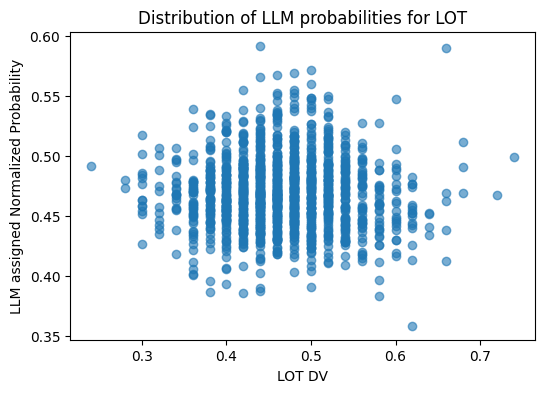

In [76]:
# ----------- some analyses ----------------------

tasks = ["BART", "CCT", "DFE", "LOT"]

for task in tasks:
    dv_col = f"{task}_DV"
    prob_col = f"{task}_llm_prob"
    
    # Top 10 most likely
    top10 = merged.nlargest(10, prob_col)[[dv_col, prob_col]].copy()
    top10["type"] = "most likely"
    
    # Top 10 least likely
    bottom10 = merged.nsmallest(10, prob_col)[[dv_col, prob_col]].copy()
    bottom10["type"] = "least likely"
    
    # Combine
    result = pd.concat([top10, bottom10], ignore_index=True)
    
    print(f"\n--- {task} ---")
    print(result)
    
    # Scatter plot
    plt.figure(figsize=(6,4))
    plt.scatter(x=merged[dv_col], y=merged[prob_col], alpha=0.6)
    plt.xlabel(f"{task} DV")
    plt.ylabel("LLM assigned Normalized Probability")
    plt.title(f"Distribution of LLM probabilities for {task}")
    plt.show()
